# Comparison to GSTools

 Cover 4 cases: 
 1) No nugget effect, data points off grid
 2) No nugget effect, data points on grid
 3) Nugget effect, data points off grid
 4) Nugget effect, data points on grid


GStools offers an easy way to create stationary Gaussian fields.

Sebastian Müller, & Lennart Schüler. (2019, January 18). *GeoStat-Framework/GSTools: Bouncy Blue (Version v1.0.1).* Zenodo. http://doi.org/10.5281/zenodo.2543658

While this module uses a Seuquential Gaussian Simulation approach to create Gaussian fields, GStools utilises a spectral method described in:

Heße, F., Prykhodko, V., Schlüter, S., & Attinger, S. (2014). *Generating random fields with a truncated power-law variogram: A comparison of several numerical methods.* Environmental Modelling and Software, 55, 32-48.

In the following notebook both methods will be compared to show the basic similarities (and differences). 

##  Creating a simple GemPy model

In a first step we create a simple GemPy model consisting of a basement and two units named "rock1" and "rock2". The layering is completetely horizontal and while model is theoretically 3D, we only have a single point depth in y driection, basically creating a single 2D cross-section. For a more detailed description take a look at the gempy
tutorials.

In [1]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
os.pardir= '../..'
# Importing GemPy
import gempy as gp
# Embedding matplotlib figures in the notebooks
%matplotlib inline
# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt
# import the kriging module
import importlib
from gempy.assets import kriging
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# set resolution, extent and input data
geo_data = gp.create_data([0,1000,0,50,0,1000],resolution=[50,1,50], 
                        path_o = os.pardir+"/data/input_data/jan_models/model1_orientations.csv",
                        path_i = os.pardir+"/data/input_data/jan_models/model1_surface_points.csv") 

Active grids: ['regular']


In [3]:
# define series and assign surfaces
gp.map_series_to_surfaces(geo_data, {"Strat_Series": ('rock2','rock1'),"Basement_Series":('basement')})

,surface,series,order_surfaces,isBasement,color,id
0,rock2,Strat_Series,1,False,#015482,1
1,rock1,Strat_Series,2,False,#9f0052,2
2,basement,Basement_Series,1,True,#ffbe00,3


In [4]:
# define the interpolator
interp_data = gp.set_interpolation_data(geo_data, compile_theano=True,
                                        theano_optimizer='fast_compile')

Compiling theano function...


WARNING (theano.gof.compilelock): Overriding existing lock by dead process '1916' (I am process '8156')


Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!


In [5]:
#calcualte the solution
sol = gp.compute_model(geo_data, compute_mesh=False)

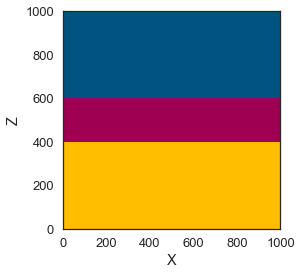

In [6]:
# Plot cross section, which is basically the whole model in this example
gp.plot.plot_section(geo_data, cell_number=0)

## The basic setup

In order to create both approaches used variograms have to be identical. Additionally the locations passed to GStools (grid) need to be the same as created by gempy.

In [7]:
# import the stuff from GStools
from gstools import krige
from gstools import SRF, Exponential
import gstools as gs

In [8]:
cond_data = np.array([[100,.5,500,2],[900,.5,500,1],[500,.5,550,1],[300,.5,400,5]])
#cond_data = np.array([[110,0,510,2],[910,0,510,1],[510,0,530,1],[310,0,410,5]])

# convert to GStools format
x_cond = cond_data[:,0]
y_cond = cond_data[:,2]
cond_val = cond_data[:,3]
x = np.arange(0,1000,20)
y = np.arange(400,600,20)

x, y = np.meshgrid(x, y)

x = x.flatten()
y = y.flatten()

In [9]:
# Set some variogram parameters:
range_ = 200
sill = np.var(cond_val)
nugget = 0

In [10]:
# create preliminary gempy kriging objects
domain = kriging.domain(sol, domain=[2], data=cond_data)
variogram_model = kriging.variogram_model('exponential', range_, sill, nugget)

In [11]:
# create preliminiary GStools stuff
model = Exponential(dim=2, var=sill-nugget , len_scale=range_, nugget=nugget)

C:\Users\Jan\Anaconda3\envs\gempy_env\lib\site-packages\gstools\covmodel\plot.py:121: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


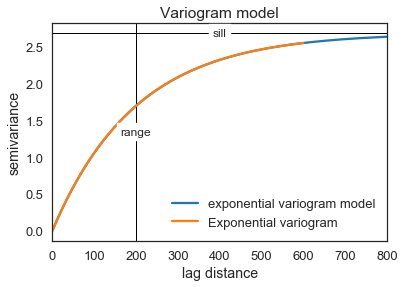

In [12]:
# Compare used variograms (exponential)
fig, ax = plt.subplots()

# GStools plotting option
variogram_model.plot()
gs.covmodel.plot.plot_variogram(model, ax=ax)

So as we can see the variogram models for both modules are the same. Good start, now we can calculate a kriged field based on these variograms:

In [13]:
# Calculation with Gempy
solution = kriging.create_kriged_field(domain, variogram_model)

C:\Users\Jan\Anaconda3\envs\gempy_env\lib\site-packages\gstools\field\plot.py:88: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


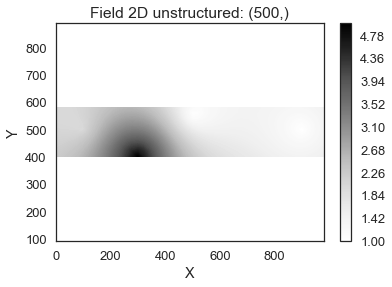

In [14]:
# Calcualtion with GSTools
srf = krige.Ordinary(model, cond_pos=(x_cond, y_cond), cond_val=cond_val)
field = srf((x, y), mesh_type='unstructured')

fig, ax = plt.subplots()
ax.axis('equal')
srf.plot(fig=fig, ax=ax)

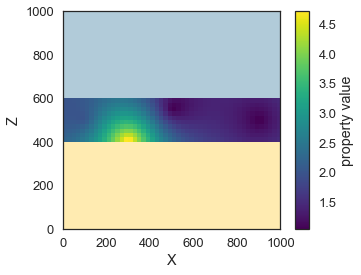

In [15]:
# Kriged field
solution.plot_results(geo_data=geo_data, prop='val', contour=False, direction='y', cell_number=0, alpha=0.7,
                          show_data=False, legend=True)


Those look pretty similar, but to be absolutely sure, let us plot them in 3D as planes, with Z being our interpolated property:

In [16]:
from mpl_toolkits.mplot3d import Axes3D

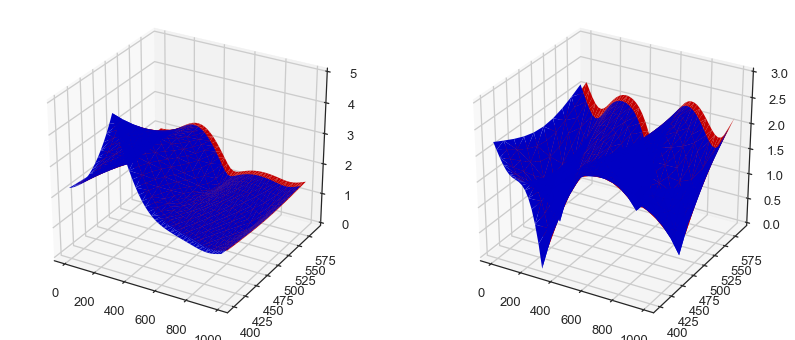

In [17]:
# Comparison as 3D surface plot:
Xs1 = solution.results_df['X'].values
Ys1 = solution.results_df['Z'].values
Zs1 = solution.results_df['estimated value'].values
Zs1b  = solution.results_df['estimation variance'].values

Xs2 = srf.pos[0]
Ys2 = srf.pos[1]
Zs2 = field[0]
Zs2b = field[1]

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax1.set_zlim(0,5)
ax2.set_zlim(0,3)

ax1.plot_trisurf(Xs2, Ys2, Zs2, color='blue', linewidth=0)
ax1.plot_trisurf(Xs1, Ys1, Zs1, color='red', linewidth=0)

ax2.plot_trisurf(Xs2, Ys2, Zs2b, color='blue', linewidth=0)
ax2.plot_trisurf(Xs1, Ys1, Zs1b, color='red', linewidth=0)

We cann see that the result really is alike. Doing the same thing in case of a nugget effect highlights the dissimilarities: The GStools solution keeps being an exact interpolator - where grid points coincide with conditioning data locations, the estimation value equals the measured value, causing a very rough behavior in these areas. Ths gempy solution utilizes a different approach (for more information see the "The Nugget effect" notebook, creating a new value at these locations.

In [18]:
# Set some variogram parameters: This time with relatively high nugget effect.
range_ = 200
sill = np.var(cond_val)
nugget = 2

In [19]:
# create preliminary gempy kriging objects
domain = kriging.domain(sol, domain=[2], data=cond_data)
variogram_model = kriging.variogram_model('exponential', range_, sill, nugget)

# create preliminiary GStools stuff
model = Exponential(dim=2, var=sill-nugget , len_scale=range_, nugget=nugget)

# Calculation with Gempy
solution = kriging.create_kriged_field(domain, variogram_model)

# Calcualtion with GSTools
srf = krige.Ordinary(model, cond_pos=(x_cond, y_cond), cond_val=cond_val)
field = srf((x, y), mesh_type='unstructured')

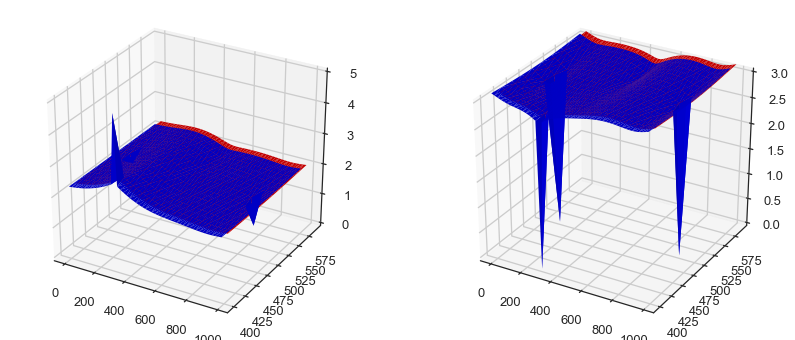

In [20]:
# Comparison as 3D surface plot:
Xs1 = solution.results_df['X'].values
Ys1 = solution.results_df['Z'].values
Zs1 = solution.results_df['estimated value'].values
Zs1b  = solution.results_df['estimation variance'].values

Xs2 = srf.pos[0]
Ys2 = srf.pos[1]
Zs2 = field[0]
Zs2b = field[1]

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax1.set_zlim(0,5)
ax2.set_zlim(0,3)

ax1.plot_trisurf(Xs2, Ys2, Zs2, color='blue', linewidth=0)
ax1.plot_trisurf(Xs1, Ys1, Zs1, color='red', linewidth=0)

ax2.plot_trisurf(Xs2, Ys2, Zs2b, color='blue', linewidth=0)
ax2.plot_trisurf(Xs1, Ys1, Zs1b, color='red', linewidth=0)

This behavoir changes dramatically if we move our conditioning data slightly off the grid, thus not exactly coinciding. The interpolation of GStools looks similar to the gempy version in this case.

In [21]:
cond_data = np.array([[110,0,510,2],[910,0,510,1],[510,0,530,1],[310,0,410,5]])

# convert to GStools format
x_cond = cond_data[:,0]
y_cond = cond_data[:,2]
cond_val = cond_data[:,3]

# parameter variogram
range_ = 200
sill = np.var(cond_val)
nugget = 2

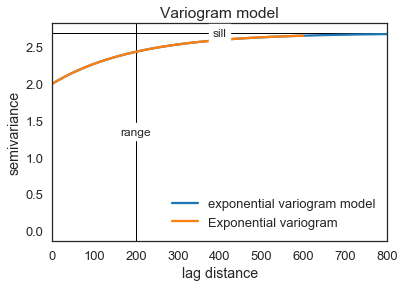

In [22]:
# Compare used variograms (exponential)
fig, ax = plt.subplots()

# GStools plotting option
variogram_model.plot()
gs.covmodel.plot.plot_variogram(model, ax=ax)

In [23]:
# create preliminary gempy kriging objects
domain = kriging.domain(sol, domain=[2], data=cond_data)
variogram_model = kriging.variogram_model('exponential', range_, sill, nugget)

# create preliminiary GStools stuff
model = Exponential(dim=2, var=sill-nugget , len_scale=range_, nugget=nugget)

# Calculation with Gempy
solution = kriging.create_kriged_field(domain, variogram_model)

# Calcualtion with GSTools
srf = krige.Ordinary(model, cond_pos=(x_cond, y_cond), cond_val=cond_val)
field = srf((x, y), mesh_type='unstructured')

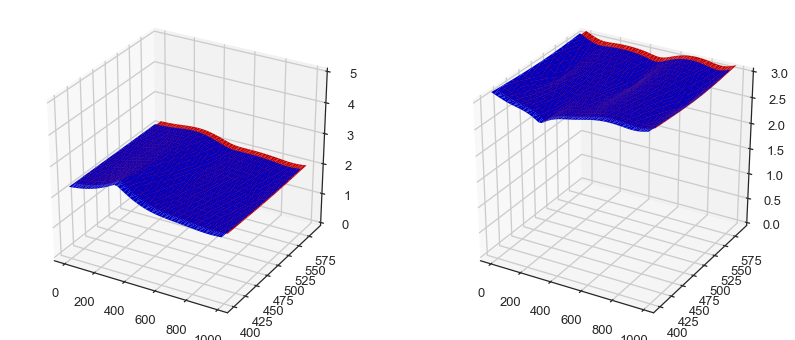

In [24]:
# Comparison as 3D surface plot:
Xs1 = solution.results_df['X'].values
Ys1 = solution.results_df['Z'].values
Zs1 = solution.results_df['estimated value'].values
Zs1b  = solution.results_df['estimation variance'].values
#print(np.max(Zs1b))

Xs2 = srf.pos[0]
Ys2 = srf.pos[1]
Zs2 = field[0]
Zs2b = field[1]
#print(np.max(Zs2b))

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax1.set_zlim(0,5)
ax2.set_zlim(0,3)

ax1.plot_trisurf(Xs2, Ys2, Zs2, color='blue', linewidth=0)
ax1.plot_trisurf(Xs1, Ys1, Zs1, color='red', linewidth=0)

ax2.plot_trisurf(Xs2, Ys2, Zs2b, color='blue', linewidth=0)
ax2.plot_trisurf(Xs1, Ys1, Zs1b, color='red', linewidth=0)